In [1]:
#Project Two
#Processing Pipeline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

from scipy.fft import fft, fftshift,rfft,rfftfreq

import os
os.chdir('project2-nmr')

In [2]:
#Preprocess the FID
df = pd.read_csv('data.csv')[150000:]

In [3]:
#make a window 

from scipy.signal import blackman
N = len(df['FID'])
w = blackman(N)

print (df['FID'].shape)
print (w.shape)

(600000,)
(600000,)


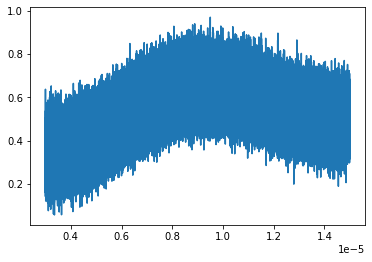

In [4]:
#array-rize my dataframe and multiply it by the window, plot to see how it looks

signal = np.array(df['FID'], dtype=float)
time = np.array(df['Time'],dtype = float)

plt.plot(time,signal)

In [5]:
#see how the fourier transform transforms the data afte rmultiplied by the window
# adjust units from mHz to MHz, fourier transform to get frequency
# used np.abs() since to get rid of the negative values

amp = np.abs(rfft(signal*w))
freq = 40960 - np.abs(rfftfreq(N,2e-11))*1e-6

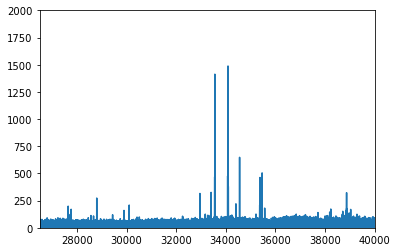

In [6]:
plt.plot(freq,amp)
plt.ylim(0,2000)
plt.xlim(26500,40000)
plt.show()

In [7]:
noise_level = np.percentile(amp, 99.95)
print(noise_level)

108.78352508210166


In [8]:
from scipy.signal import find_peaks

peak_indexes,peak_heights = find_peaks(amp, height = noise_level)

#print(peak_indexes)
#print(peak_heights)
#for ii,index in enumerate(peak_indexes):
#    print(f"Frequency {freq[index]} has an amplitdue of {amp[index]}")

In [9]:
import scipy.optimize as opt
from scipy.optimize import curve_fit

def gauss(x, y0,A, x0, w):
    return y0 + A * np.exp(-(x - x0) ** 2 / (2 * w ** 2))

/Users/mirandalu/miniconda3/envs/che155/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


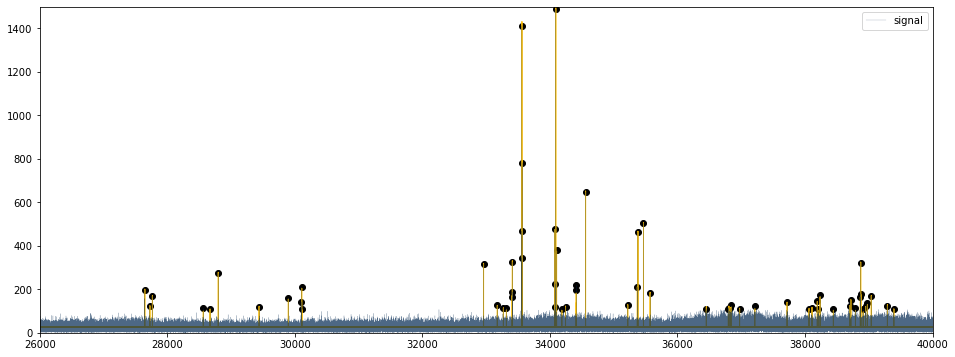

In [10]:
#create empty lists to export reports
export_data={
    "y0":[],
    "A":[],
    "x0":[],
    "w":[],
    "e(y0)":[],
    "e(A)":[],
    "e(x0)":[],
    "e(w)":[],
    }

fig,ax = plt.subplots(figsize=(16,6))
for index in peak_indexes:
    amplitude=amp[index]
    center_freq=freq[index]
    #print(f"Fitting curve index {ii}: freq: {center_freq} amp: {amplitude}")
    
    parameters, covariances = curve_fit(gauss, freq, amp, p0=[noise_level,amplitude,center_freq, 0.13])
    ax.plot(freq, gauss(freq, *parameters), color='#FFBF00', linewidth=1., alpha=0.9)
    
    y0=parameters[0]
    A=parameters[1]
    x0=parameters[2]
    w=parameters[3]
    ey0=covariances[0]
    eA=covariances[1]
    ex0=covariances[2]
    ew=covariances[3]
    
    export_data["y0"].append(y0)
    export_data["A"].append(A)
    export_data["x0"].append(x0)
    export_data["w"].append(w)
    export_data["e(y0)"].append(ey0)
    export_data["e(A)"].append(eA)
    export_data["e(x0)"].append(ex0)
    export_data["e(w)"].append(ew)
    
    plt.scatter(freq[index],amp[index],color = '#000000') #plot peaks
    
ax.plot(freq,amp,color='#022851',linewidth=0.2,alpha = 0.7,label = "signal") #plot signals
ax.set_ylim(0, 1500)
ax.set_xlim(26000, 40000)
ax.legend()
fig.show()

In [11]:
#export results
out_df = pd.DataFrame(export_data)
out_df.to_csv("results.csv")

In [12]:
# plot the top 6 peaks from the results file
df2 = pd.read_csv('results.csv')
df2 = df2.sort_values(by='A',ascending=False)
# print(df2.head(6))